# Содержание 

[1. Загрузка и подготовка данных](#section1)

[2. Анализ продукта](#section2)

[3. Анализ продаж](#section3)

[4. Анализ маркетинга](#section4)

[5. Общий вывод](#section5)

### Задача: помочь маргетологам оптимизировать затраты. 

In [85]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

<a id='section1'></a>
## Загрузка данных и подготовка к анализу

Загрузим данные о визитах, заказах пользователей и расходах на рекламу 

In [86]:
data_visits = pd.read_csv('/datasets/visits_log.csv')
data_orders = pd.read_csv('/datasets/orders_log.csv')
data_costs = pd.read_csv('/datasets/costs.csv')

Вызовем информацию о каждом датафрейме 

In [87]:
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Uid — уникальный идентификатор пользователя

Device — категория устройства пользователя

Start Ts — дата и время начала сессии

End Ts — дата и время окончания сессии

Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [88]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Uid — уникальный id пользователя, который сделал заказ

Buy Ts — дата и время заказа

Revenue — выручка с этого заказа

In [89]:
data_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


source_id — идентификатор рекламного источника

dt — дата

costs — затраты на этот рекламный источник в этот день

Скорректируем названия столбцов для удобной работы 

In [90]:
data_visits.rename(columns={'Uid': 'uid', 'Device': 'device', 'End Ts' : 'end_ts', 'Source Id' : 'source_id', 
                            'Start Ts' : 'start_ts'},inplace=True)

In [91]:
data_orders.rename(columns={'Buy Ts' : 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'}, inplace = True)

Приведем столбцы с датами в формат, необходимый для работы 

In [92]:
data_visits['start_ts'] = pd.to_datetime(data_visits['start_ts'], format ='%d.%m.%Y %H:%M' )
data_visits['end_ts'] = pd.to_datetime(data_visits['end_ts'], format ='%d.%m.%Y %H:%M' )
data_orders['buy_ts'] = pd.to_datetime(data_orders['buy_ts'], format ='%Y-%m-%d %H:%M' )
data_costs['dt'] = pd.to_datetime(data_costs['dt'], format ='%Y-%m-%d' )

# Построение отчетов и расчет метрик 

<a id='section2'></a>
## Продукт

### Сколько людей пользуются в день, неделю, месяц?

Для ответа на этот вопрос выделим из даты первого визита необходимый нам маштаб (день, неделя, месяц)

In [93]:
data_visits['session_date'] = data_visits['start_ts'].dt.date
data_visits['session_year'] = data_visits['start_ts'].dt.year
data_visits['session_week'] = data_visits['start_ts'].dt.week
data_visits['session_month'] = data_visits['start_ts'].dt.month

In [94]:
data_visits.head(10)

,uid,device,end_ts,source_id,start_ts,session_date,session_year,session_week,session_month
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,2017-12-20,2017,51,12
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,2018-02-19,2018,8,2
2,7459035603376831527,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,2017-07-01,2017,26,7
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,2018-05-20,2018,20,5
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,2017-12-27,2017,52,12
5,16007536194108375387,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,2017-09-03,2017,35,9
6,6661610529277171451,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,2018-01-30,2018,5,1
7,11423865690854540312,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,2017-11-05,2017,44,11
8,2987360259350925644,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2017-07-19,2017,29,7
9,1289240080042562063,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,2017-11-08,2017,45,11


Сгруппируем по необходимому масштабу и посчитаем количество уникальных пользователей. 

In [95]:
visits_day_users = data_visits.groupby('session_date').agg({'uid':'nunique'})
visits_week_users = data_visits.groupby(['session_year','session_week']).agg({'uid':'nunique'})
visits_month_users = data_visits.groupby(['session_year','session_month']).agg({'uid':'nunique'})

Посчитаем среднее количество пользователей по каждому временному масштабу. 

In [96]:
print('Продуктом пользуется в день:', visits_day_users['uid'].mean().round())
print('Продуктом пользуется в неделю:', visits_week_users['uid'].mean().round())
print('Продуктом пользуется в месяц:', visits_month_users['uid'].mean().round())

Продуктом пользуется в день: 908.0
Продуктом пользуется в неделю: 5716.0
Продуктом пользуется в месяц: 23228.0


### Сколько сессий в день?

Рассчитаем сколько сессий пользователи совершают в день. Сгруппируем данные по дням и посчитаем количество пользователй.

In [97]:
session_day_users = data_visits.groupby('session_date').agg({'uid':'count'})

Рассчитаем среднее количество сессий в день 

In [98]:
print('Сессий в день:',session_day_users['uid'].mean().round())

Сессий в день: 985.0


### Сколько длится одна сессия?

Для рассчета длительности сессии. Рассчитаем дельту времени каждаго визита и выразим ее в отдельный столбец в секундах. 

In [99]:
data_visits['session_duration_sec'] = (data_visits['end_ts']-data_visits['start_ts']).dt.seconds

Среди полученных данных выделяем моду.Мода - это значение которое чаще всего повторяется. 

In [100]:
asl = data_visits['session_duration_sec'].mode() # значение которое повтор чаще всего

In [101]:
print('Продолжительность одной сессии в секундах : ', asl[0])

Продолжительность одной сессии в секундах :  60


### Как часто люди возвращаются?

Найдем показатель Retention Rate, который даст нам представление как часто возвращаются пользователи. 

Выясним когда пользователи заходили на сайт впервые. Определим месяц в котором они заходили на сайт впервые. 

In [102]:
user_activity = data_visits[['uid','session_date','source_id','device']]

In [103]:
first_activity_day = user_activity.groupby(['uid'])['session_date'].min() # нахожу первый заход на сайит
first_activity_day.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_day, on = 'uid') #добовляем столбец
user_activity['session_month'] = user_activity['session_date'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

Найдем время жизни когорты вычтем из даты захода дату первого посешения. Переведем в месяцы.

In [104]:
user_activity['cohorts_lifetime'] = user_activity['session_month'] - user_activity['first_activity_month']# время жизни когорты 
user_activity['cohorts_lifetime'] = user_activity['cohorts_lifetime'] / np.timedelta64(1,'M') #перевожу в месяца
user_activity['cohorts_lifetime'] = user_activity['cohorts_lifetime'].round()
user_activity['cohorts_lifetime'] = user_activity['cohorts_lifetime'].astype('int')

Найдем количество уникальных пользователей в каждом месяце

In [105]:
cohorts = user_activity.groupby(['first_activity_month','cohorts_lifetime']).agg({
    'uid':'nunique'}).reset_index() #количество активных пользователей на каждый месяц 

Найдем количество пользователей изначально в каждой когорте 

In [106]:
inital_users_count = cohorts[cohorts['cohorts_lifetime'] == 0][[
    'first_activity_month','uid']]#число пользователей изначально в каждой когорте
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})

In [107]:
cohorts = cohorts.merge(inital_users_count, on = 'first_activity_month')

Найдем retention каждой когорты 

In [108]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

Построим сводную таблицу и на основание ее тепловую карту 

In [109]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohorts_lifetime',values='retention',aggfunc='sum')

In [110]:
retention_pivot

cohorts_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


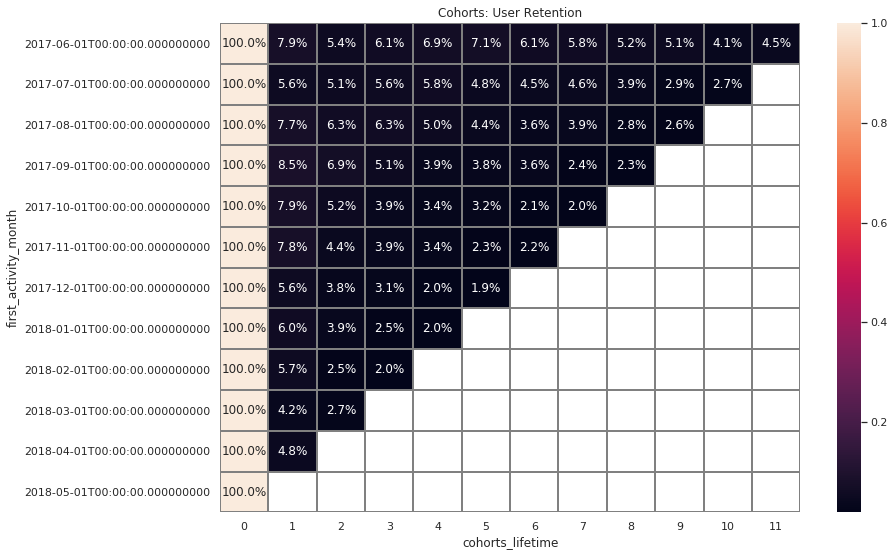

In [111]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

Из построенного графика сделаем вывод, что после первого посещения люди редко возвращаются на сайт. Возможно, это обусловлено спецификой сайта по продаже билетов на различные мероприятия. 

## Продажи

<a id='section3'></a>
## Когда люди начинают покупать?

Перед тем как приступить как анализу продаж добавим данные объ источниках привлечения к датафрейму с продажами. Объединять датафремы будем исходя из первго захода на сайт. 

In [112]:
first_session = data_visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_session = first_session.merge(data_visits[['uid','start_ts','source_id','device']], on =['uid','start_ts'])
first_session.rename(columns={'start_ts':'first_start_ts'},inplace = True)
data_orders = data_orders.merge(first_session, on = 'uid')

Для определения когда люди начинают покупать найдем первую дату покупки.

In [113]:
first_orders = data_orders.groupby('uid')['buy_ts'].min() # тут первая покупка
first_orders.name = 'first_order'
data_orders = data_orders.join(first_orders, on = 'uid')

In [114]:
data_orders.head(5)

,buy_ts,revenue,uid,first_start_ts,source_id,device,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00


In [115]:
data_orders['first_session_date'] = data_orders['first_start_ts'].dt.date

In [116]:
data_orders['first_order_date'] = data_orders['first_order'].dt.date

In [117]:
data_orders.head(10)

,buy_ts,revenue,uid,first_start_ts,source_id,device,first_order,first_session_date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,3,desktop,2017-06-01 08:43:00,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:51:00,5,desktop,2017-06-01 08:54:00,2017-06-01,2017-06-01
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:51:00,5,desktop,2017-06-01 08:54:00,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 18:34:00,5,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 18:34:00,5,desktop,2017-06-01 09:22:00,2017-06-01,2017-06-01


Затем найдем разницу между первым заходом на сайт и покупкой и выразим его в минутах 

In [118]:
data_orders['delta_time_order'] = (data_orders['first_order'] - data_orders['first_start_ts']) / np.timedelta64(1,'m')

In [119]:
data_orders.head(5)

,buy_ts,revenue,uid,first_start_ts,source_id,device,first_order,first_session_date,first_order_date,delta_time_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop,2017-06-01 00:10:00,2017-06-01,2017-06-01,1.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop,2017-06-01 00:25:00,2017-06-01,2017-06-01,11.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop,2017-06-01 00:27:00,2017-06-01,2017-06-01,2.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop,2017-06-01 00:29:00,2017-06-01,2017-06-01,15.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop,2017-06-01 07:58:00,2017-06-01,2017-06-01,27.0


Построим гисторамму распределения дельты времени. Откинем при этом аномальные значания 

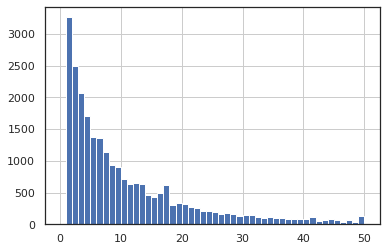

In [120]:
data_orders.query('delta_time_order > 0 ')['delta_time_order'].hist(bins = 50, range = (0, 50))
plt.show()

Рассчитаем медианное значение дельты времени 

In [121]:
delta_time_mode = data_orders['delta_time_order'].mode()

In [122]:
delta_time_mode

0    1.0
dtype: float64

В среденм пользователеь совершает заказ через минуту прибывания на сайте. Из этого можно сделать вывод, что в большинстве, пользователи уже заранее знают, что хотят заказать. 

## Сколько раз покупают за период?

Найдем количество покупок за день, неделю и месяц.

In [123]:
data_orders['buy_date'] = data_orders['buy_ts'].dt.date

In [124]:
count_buy_date = data_orders.groupby(data_orders['buy_ts'].dt.date)['uid'].count()

In [125]:
count_buy_week = data_orders.groupby([data_orders['buy_ts'].dt.year, data_orders['buy_ts'].dt.week])['uid'].count()

In [126]:
count_buy_month = data_orders.groupby([data_orders['buy_ts'].dt.year, data_orders['buy_ts'].dt.month])['uid'].count()

In [127]:
print('Среднее количестов покупок за день',count_buy_date.mean().round())
print('Среднее количестов покупок за неделю',count_buy_week.mean().round())
print('Среднее количестов покупок за месяц',count_buy_month.mean().round())

Среднее количестов покупок за день 139.0
Среднее количестов покупок за неделю 951.0
Среднее количестов покупок за месяц 3878.0


## Какой средний чек?

Найдем сумму всех покупок построим гистограмму распределения покупок.

In [128]:
#revenue = data_orders.groupby('uid').agg({'revenue' : 'sum'})

In [129]:
#revenue['revenue'].hist(bins = 100, range=(0,20))
#plt.show()

Найдем медианное значение покупки. 

In [130]:
#revenue_mean = revenue['revenue'].median()

<a id='section6'></a>
Посчитаем среднее значение чека по каждому месяцу.  Для этого посчитаем количество людей, которые совершили покупки в каждом месяце и сумму этих покупок. Разделим сумму на количество людей. Затем построим график. 

In [131]:
mean_check = data_orders.groupby(data_orders['buy_ts'].astype('datetime64[M]')).agg({'uid':'nunique','revenue':'sum'})

In [132]:
mean_check['mean_check'] = (mean_check['revenue']  / mean_check['uid']).round(2)

In [133]:
mean_check = mean_check.reset_index()

In [134]:
mean_check

,buy_ts,uid,revenue,mean_check
0,2017-06-01,2023,9557.49,4.72
1,2017-07-01,1984,12539.47,6.32
2,2017-08-01,1472,8758.78,5.95
3,2017-09-01,2750,18345.51,6.67
4,2017-10-01,4675,27987.70,5.99
5,2017-11-01,4547,27069.93,5.95
6,2017-12-01,4942,36388.60,7.36
7,2018-01-01,3898,19417.13,4.98
8,2018-02-01,4258,25560.54,6.00
9,2018-03-01,4181,28834.59,6.90


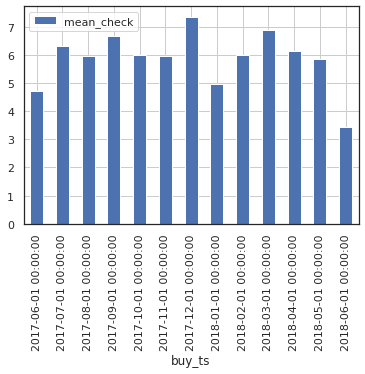

In [135]:
mean_check.plot.bar(x='buy_ts', y='mean_check', grid = True )
plt.show()

## Сколько денег приносят? (LTV)

Для расчета показателя сколько денег приносят клиенты. Разобъем всех покупателей на когорты и вычислим сколько приносит денег каждая когорта с течением времени.

Вычислим численость каждой когорты. Сгруппируем данные по месяцу первой покупки и найдем количество уникальных покупателей в каждой группе 

In [136]:
cohorts_size = data_orders.groupby(data_orders['first_order'].astype('datetime64[M]')).agg({'uid':'nunique'}).reset_index()
cohorts_size.columns = ['first_order','buyers']

Найдем суммарную прибыль с каждой когорты. 

In [137]:
cohorts = data_orders.groupby([data_orders['first_order'].astype('datetime64[M]'),
                               data_orders['buy_ts'].astype('datetime64[M]')]).agg({'revenue' : 'sum'}).reset_index()

In [138]:
report = pd.merge(cohorts,cohorts_size, on = 'first_order')

In [139]:
report.head(5)

,first_order,buy_ts,revenue,buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


Найдем возраст каждой когорты 

In [140]:
report['age'] = (report['buy_ts']- report['first_order']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [141]:
report.head(5)

,first_order,buy_ts,revenue,buyers,age
0,2017-06-01,2017-06-01,9557.49,2023,0
1,2017-06-01,2017-07-01,981.82,2023,1
2,2017-06-01,2017-08-01,885.34,2023,2
3,2017-06-01,2017-09-01,1931.30,2023,3
4,2017-06-01,2017-10-01,2068.58,2023,4


Рассчитаем ltv каждой когорты. Построим сводную таблицу. К сводной таблице применяем метод cumsum поскольку ltv накопительная метрика и значение ltv постоянно складывается со следующим. 

In [142]:
report['ltv'] = report['revenue'] / report['buyers']

In [143]:
pivot_report= report.pivot_table(index = 'first_order', columns = 'age', values = 'ltv',aggfunc = 'mean')


In [144]:
pivot_report.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из данной таблицы наблюдаем чем равен ltv для каждой когорты по времени.

<a id='section7'></a>
Расчитаем среднее значени ltv за 12 месяцев по всем когортам.

In [145]:
pivot_report.cumsum(axis=1).mean(axis = 0).round(2)

first_order
2017-06-01     8.53
2017-07-01     7.47
2017-08-01     7.06
2017-09-01    10.51
2017-10-01     5.87
2017-11-01     5.92
2017-12-01     6.27
2018-01-01     4.62
2018-02-01     4.42
2018-03-01     5.14
2018-04-01     4.92
2018-05-01     4.66
2018-06-01     3.42
dtype: float64

In [146]:
report.head(10)

,first_order,buy_ts,revenue,buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531
5,2017-06-01,2017-11-01,1487.92,2023,5,0.735502
6,2017-06-01,2017-12-01,1922.74,2023,6,0.950440
7,2017-06-01,2018-01-01,1176.56,2023,7,0.581592
8,2017-06-01,2018-02-01,1119.15,2023,8,0.553213
9,2017-06-01,2018-03-01,1225.51,2023,9,0.605788


<a id='section4'></a>
## Маркетинг

## Сколько денег потратили? Всего / на каждый источник / по времени

Рассчитаем сколько всего было потрачено на рекламу. Просуммируем все затраты.

In [147]:
costs_all = data_costs['costs'].sum()

In [148]:
print('Потрачено денег на рекламу:',costs_all)

Потрачено денег на рекламу: 329131.62


Рассчитаем какое количество денег потрачено на каждый источник. Сгруппируем по источникам и посчитаем сумму. 

In [149]:
costs_source = data_costs.groupby('source_id')['costs'].sum()

In [150]:
costs_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

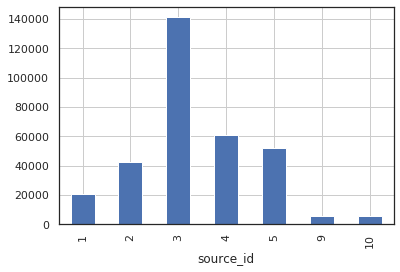

In [151]:
costs_source.plot.bar(grid = True)
plt.show()

Рассчитаем количество денег потраченное на рекламу каждый месяц

In [152]:
costs_month = data_costs.groupby(data_costs['dt'].astype('datetime64[M]'))['costs'].sum().reset_index()

In [153]:
costs_month

,dt,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


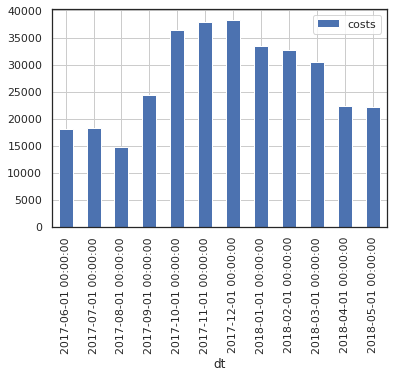

In [154]:
costs_month.plot.bar(x = 'dt', grid = 'True')
plt.show()

## Сколько стоило привлечение одного покупателя из каждого источника?

Для расчета CAC нам необходимо объеденить таблицу с заказами с таблицой затрат на рекламные источники. После чего разделить затраты в каждом истонике на количество пользователей в этом источнике. 

Сгрупируем затраты по дате и источнику и посчитаем сумму затрат в день по каждому истонику.

In [155]:
cost_groupby = data_costs.groupby(['dt','source_id'])['costs'].agg({'costs':'sum'})
cost_groupby.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


costs
dt         source_id        
2017-06-01 1           75.20
           2          132.56
           3          349.38
           4           76.74
           5           73.24

Из таблицы с заказами найдем первый заход пользователя на сайт. Мы будем отталкиватся при рассчетах от первого захода на сайт пользователя считаем за привлеченного по рекламе. 

In [156]:
revenue_users = data_orders[['uid','first_session_date','source_id','revenue']]
revenue_users .columns = ['uid','dt','source_id','revenue']

Сгруппируем данные и соединим с таблицой затрат. Объединим две таблицы.

In [157]:
revenue_users  = revenue_users.groupby(['dt','source_id'])['uid','revenue'].agg({'uid':'nunique','revenue' :'sum'})

In [158]:
report_costs = cost_groupby.join(revenue_users ).reset_index()

Рассчитаем затраты на каждого пользователя по итсоникам разделив затраты на количество пользователей. 

In [159]:
report_costs ['cac'] = report_costs ['costs'] / report_costs ['uid']

In [160]:
report_costs .head(10)

,dt,source_id,costs,uid,revenue,cac
0,2017-06-01,1,75.20,22.0,2373.47,3.418182
1,2017-06-01,2,132.56,28.0,3044.31,4.734286
2,2017-06-01,3,349.38,46.0,404.30,7.595217
3,2017-06-01,4,76.74,32.0,386.02,2.398125
4,2017-06-01,5,73.24,22.0,1618.55,3.329091
5,2017-06-01,9,13.06,17.0,265.35,0.768235
6,2017-06-01,10,15.08,3.0,7.34,5.026667
7,2017-06-02,1,62.25,12.0,248.18,5.187500
8,2017-06-02,2,132.38,25.0,253.11,5.295200
9,2017-06-02,3,314.22,34.0,130.61,9.241765


Построим графики средние затраты на каждого пользователя по источнику и времени. 

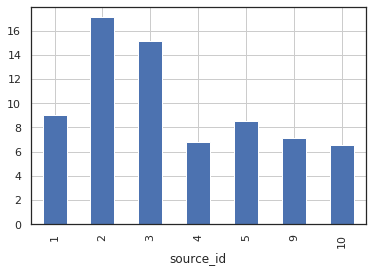

In [161]:
report_costs.groupby('source_id')['cac'].mean().plot.bar(grid = True)
plt.show()

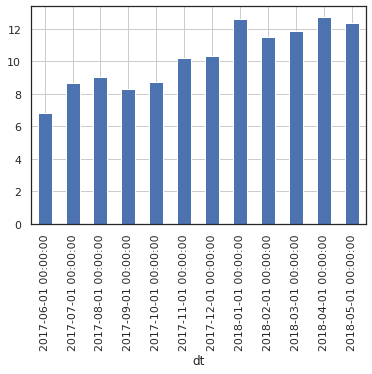

In [162]:
report_costs.groupby(report_costs ['dt'].astype('datetime64[M]'))['cac'].mean().plot.bar(grid = True)
plt.show()

Самые высокие среднении затраты у источников 2 и 3. Затраты на одного пользователя постепенно растут со временем.

## На сколько окупились расходы? (ROI)

Рассчитаем на сколько окупились расходы на рекламу. Для этого вычтем из прибыли затраты на рекламу и это число поделим на затраты на рекламу. 

In [163]:
report_costs ['roi'] = (report_costs ['revenue'] - report_costs ['costs']) / report_costs ['costs']

In [164]:
#sellers_visit.head(10)

In [165]:
report_costs.head(5)

,dt,source_id,costs,uid,revenue,cac,roi
0,2017-06-01,1,75.20,22.0,2373.47,3.418182,30.562101
1,2017-06-01,2,132.56,28.0,3044.31,4.734286,21.965525
2,2017-06-01,3,349.38,46.0,404.30,7.595217,0.157193
3,2017-06-01,4,76.74,32.0,386.02,2.398125,4.030232
4,2017-06-01,5,73.24,22.0,1618.55,3.329091,21.099263


Построим графики средних значенией окупаемости прибыли по источника и месяцам.

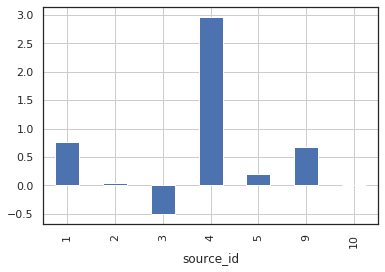

In [166]:
report_costs .groupby('source_id')['roi'].mean().plot.bar(grid = True)
plt.show()

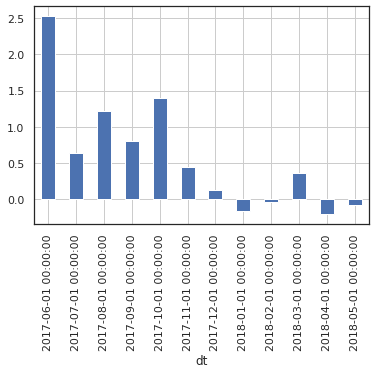

In [167]:
report_costs .groupby(report_costs ['dt'].astype('datetime64[M]'))['roi'].mean().plot.bar(grid = True )
plt.show()

Из графиков можно сделать вывод что большую прыбыль приносит источник 4. Источники 1 и 9 почти окупают себя. В целом по времени источники окупали себя только в июне , августе и октябре. В остальных месяцах окупаемости не было. 

<a id='section5'></a>
# Выводы 

Из полученных результатов можно сделать выводы:
1. Пользователи заходящие на сайт уже знаю что хотят купить это показывают показатели (средняя продолжительность сесси = 60 секунд  и когда люди совершают покупку в среднем через 60 секунд после нахождения на сайте).
2. Возврат пользователей - низкий, пользователь покупает что ему нужно и возращается не часто. 
3. Рекламные расходы за год полностью окупили себя только в двух месяцах. Единственным окупаем ым источником является источник 4.

Рекомендации маркетологам : 
1. Продолжать вкладывать деньги в рекламный источник 4. Поскольку у него самый высокий roi. 
2. Сократить вкладывание денег из источников 2,3,5,10 поскольку они не окупают себя, очень низкий показатель roi
3. Увеличить вкладывание денег в источники 1,9 поскольку их выше 60% они могут начать окупать себя и приносить прибыль. 
